In [54]:
# Data preparation for Ph.D thesis
# copy from INDICATORS_DATASET_RAW_DATA_FOR_TS-GENERATOR-PARSING.ipynb
# @author: Andres L. Suarez-Cetrulo
%config IPCompleter.greedy=True
%load_ext jupyternotify
%matplotlib inline

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [55]:
# Imports
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import os
import matplotlib.pyplot as plt

# Using TALib abstract API to create a dictionary of technical indicators to iterate later.
from talib import abstract

#### The first step is to run 1_rawdata_processing.py in the project QuantQuoteDataPreprocessing. 
- Run this for the desired ETF symbols, frequency and period (check in config.yaml).
- Move output files to the input directory of the next cell below ('path' val)

#### Then, parse the series (removing out of market hours)

In [56]:
# path = os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data','efts','30min-level',
#                     'IBEX','IBEX_[2017-01-01_to_2018-01-01]'])
sources = ['DOWJONES','S&P500', 'IBEX', 'NASDAQ']
date_ranges = ['[2014-12-01_to_2015-01-01]' ,'[2015-01-01_to_2016-01-01]', '[2016-01-01_to_2017-01-01]', 
               '[2017-01-01_to_2018-01-01]', '[2018-01-01_to_2019-01-01]']
files = list()
level = '1min-level'
for source in sources:
    print(source)
    for date_rng in date_ranges:
        print(date_rng)
        path = os.sep.join(['C:','Users','suare','data', 'analysis','quantquote', level,
                            source,'_'.join([source, date_rng, 'no_missing_data'])])  # new - moving data across
        df = pd.read_csv(path+'.csv.gz', sep=';', compression='gzip')
        df.index = pd.to_datetime(df.datetime)
        df.drop(columns=['datetime'], inplace=True)
        df.sort_index(inplace=True)
        df = df.between_time('09:30','16:00')
        df.head()
        path = os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data','efts','5min-level',
                    source,'_'.join([source, date_rng, 'no_missing_data'])])
        df.to_csv(path+'_market_hours_no_missing_data.csv', sep=';')
#         os.remove(path+'_market_hours.csv')
        files.append(path+'_market_hours_no_missing_data.csv')
# files

DOWJONES
[2014-12-01_to_2015-01-01]
[2015-01-01_to_2016-01-01]
[2016-01-01_to_2017-01-01]
[2017-01-01_to_2018-01-01]
[2018-01-01_to_2019-01-01]
S&P500
[2014-12-01_to_2015-01-01]
[2015-01-01_to_2016-01-01]
[2016-01-01_to_2017-01-01]
[2017-01-01_to_2018-01-01]
[2018-01-01_to_2019-01-01]
IBEX
[2014-12-01_to_2015-01-01]
[2015-01-01_to_2016-01-01]
[2016-01-01_to_2017-01-01]
[2017-01-01_to_2018-01-01]
[2018-01-01_to_2019-01-01]
NASDAQ
[2014-12-01_to_2015-01-01]
[2015-01-01_to_2016-01-01]
[2016-01-01_to_2017-01-01]
[2017-01-01_to_2018-01-01]
[2018-01-01_to_2019-01-01]


#### Now let's define indicators, paths, and start the transformation process

In [43]:
# Creating a dictionary of technical indicators using TALib abstract API
indicators = ['sma','ema','wma','mom','stoch','macd' ,'rsi' ,'willr',
              'adosc' ,'cci','adx','aroon' ,'bbands','obv' ,'trima',
              'roc' ,'rocr','stochf','medprice','typprice','wclprice',
              'atr','macdfix','mfi' ,'sar' ,'ppo']

def get_indicator(ind: str):
    return abstract.Function(ind)

# Add as many indicators as necessary: see all indicators in https://mrjbq7.github.io/ta-lib/

In [44]:
import subprocess
# Define this to parse the CSVs to ARFF later automatically
def create_arff_file(filename):
    java_mem = '-Xmx3074m'
    filename = filename.replace('.csv', '')
    wekadev_libpath = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\lib\\weka-dev-3.7.12.jar'
    command = ['java', java_mem, '-classpath', wekadev_libpath,
               'weka.core.converters.CSVLoader', filename + '.csv', '>', filename + '.arff']
    f = open(filename + '.arff', "w")
    subprocess.call(command, stdout=f)
    print('If the arff is not generated, run the next in the terminal.')
    print(str(' '.join(command)))

In [45]:
# Paths for symbols (not eft)
DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data'])
# '/Users/asuarez/Downloads'
SOURCE_PATH=DATA_PATH # +'raw\\alpha_vantage\\S&P500\\symbols\\AAPL\\'  # 'raw/alpha_vantage/'
RESULT_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output']) # +'analysis\\'+SYMBOL.lower()+'\\'

# List of dates for files to be loaded
# raw_datasets = ['aapl\\APPLE_[2018-08-01_to_2018-09-11]_5min.csv',
#                   'btc\\BITCOIN_[2019-07-01_to_2019-07-15]_5min.csv',
#                   'xrp\\RIPPLE_[2019-07-01_to_2019-08-01]_5min.csv',
#                   'efts\\5min-level\\DOWJONES\\DOWJONES_[2015-08-01_to_2015-08-31]_market_hours.csv']
raw_datasets = ['efts\\'+level+'\\DOWJONES\\DOWJONES_[2015-01-01_to_2016-01-01]_market_hours.csv']
    
filename = raw_datasets[0] # 'timeseries_created_21-10-2019' # 'timeseries_created_1571527428'
FIELD = 'close' # price->'ts' returns->'ret_ts' ts_with_added_noise-> 'ts_n2_post'

file = os.sep.join([SOURCE_PATH, filename])
RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_indicators_best_17052020.csv'])

In [46]:
# Open file
df=pd.read_csv(file, sep=';')
print(df.head())

df['close'] = df[FIELD]
df.close.head()

              datetime      open      high       low    close   volume  gap  \
0  2015-01-02 09:30:00  178.6200  178.7300  178.5601  178.660  84826.0  0.0   
1  2015-01-02 09:31:00  178.6800  178.7154  178.5701  178.690  19078.0  0.0   
2  2015-01-02 09:32:00  178.7099  178.8040  178.6800  178.804  12179.0  0.0   
3  2015-01-02 09:33:00  178.7950  178.8900  178.7700  178.890  16965.0  0.0   
4  2015-01-02 09:34:00  178.8900  178.9100  178.8300  178.870  22910.0  0.0   

    timestamp  
0  1420191000  
1  1420191060  
2  1420191120  
3  1420191180  
4  1420191240  


0    178.660
1    178.690
2    178.804
3    178.890
4    178.870
Name: close, dtype: float64

In [47]:
#Add parameters to transform in TS
timeseries=['close', 'open', 'high', 'low']
#Length of the TS. How many values do we keep per serie. 
# e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3
length = 5

# Add lagged times
for column in timeseries:
    #df[column+'_t']=df[column]
    for i in range(1,length):
        df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed
    #del drops the delected df column
    #del df[column]
df.head()

,datetime,open,high,low,close,volume,gap,timestamp,close_t-1,close_t-2,...,open_t-3,open_t-4,high_t-1,high_t-2,high_t-3,high_t-4,low_t-1,low_t-2,low_t-3,low_t-4
0,2015-01-02 09:30:00,178.6200,178.7300,178.5601,178.660,84826.0,0.0,1420191000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02 09:31:00,178.6800,178.7154,178.5701,178.690,19078.0,0.0,1420191060,178.660,NaN,...,NaN,NaN,178.7300,NaN,NaN,NaN,178.5601,NaN,NaN,NaN
2,2015-01-02 09:32:00,178.7099,178.8040,178.6800,178.804,12179.0,0.0,1420191120,178.690,178.660,...,NaN,NaN,178.7154,178.7300,NaN,NaN,178.5701,178.5601,NaN,NaN
3,2015-01-02 09:33:00,178.7950,178.8900,178.7700,178.890,16965.0,0.0,1420191180,178.804,178.690,...,178.62,NaN,178.8040,178.7154,178.7300,NaN,178.6800,178.5701,178.5601,NaN
4,2015-01-02 09:34:00,178.8900,178.9100,178.8300,178.870,22910.0,0.0,1420191240,178.890,178.804,...,178.68,178.62,178.8900,178.8040,178.7154,178.73,178.7700,178.6800,178.5701,178.5601


In [30]:
# all the numbers here and below assume a default time period for ta params of 10 mins averages
# change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
# in that case change as well the time tag '_10' with the corresponding one.
default_timerange=10
# Set extra timeranges for moving averages
extra_timeranges=[default_timerange/2, default_timerange, default_timerange*2, default_timerange*3]

# ###########################################
# Iterate and run list of indicators selected
# All of them produced for 25 prior mins of data 
# ###########################################
for ind in list(indicators):
    if ind not in ['adosc', 'obv', 'mfi']:  # avoiding indicators that need volume
        # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
        if ind in ['ema','sma','trima']:
            for timerange in extra_timeranges:
                df[ind+'_'+str(int(timerange))] = get_indicator(ind)(df, timeperiod=timerange) 
        elif ind not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
            df[ind+'_'+str(int(default_timerange))] = get_indicator(ind)(df, timeperiod=(default_timerange))
        # Otherwise check the list of columns and return all
        else: 
            key_output=get_indicator(ind)(df, timeperiod=(default_timerange)) #, price='close')
            for j in range(0,len(list(key_output.columns))):
                df[ind+'_'+key_output.columns[int(j)]] = key_output[key_output.columns[j]]
df.head()

,datetime,open,high,low,close,volume,gap,timestamp,close_t-1,close_t-2,...,stochf_fastd,medprice_10,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10
0,2015-01-02 09:30:00,178.6200,178.7300,178.5601,178.660,84826.0,0.0,1420191000,NaN,NaN,...,NaN,178.64505,178.650033,178.652525,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02 09:31:00,178.6800,178.7154,178.5701,178.690,19078.0,0.0,1420191060,178.660,NaN,...,NaN,178.64275,178.658500,178.666375,NaN,NaN,NaN,NaN,178.560100,NaN
2,2015-01-02 09:32:00,178.7099,178.8040,178.6800,178.804,12179.0,0.0,1420191120,178.690,178.660,...,NaN,178.74200,178.762667,178.773000,NaN,NaN,NaN,NaN,178.563206,NaN
3,2015-01-02 09:33:00,178.7950,178.8900,178.7700,178.890,16965.0,0.0,1420191180,178.804,178.690,...,NaN,178.83000,178.850000,178.860000,NaN,NaN,NaN,NaN,178.570100,NaN
4,2015-01-02 09:34:00,178.8900,178.9100,178.8300,178.870,22910.0,0.0,1420191240,178.890,178.804,...,NaN,178.87000,178.870000,178.870000,NaN,NaN,NaN,NaN,178.589294,NaN


In [31]:
def set_label(row):
    if row['close_t+1'] > row['close']: return 1
    else: return 0

# One minute ahead closing price
df['close_t+1']=df['close'].shift(-1)

# Creating label/y to be predicted / independent (predicted) feature 'y' 
df['label'] = df.apply(set_label, axis=1)
# df.drop(columns=['n_row', 'new_switch', 'cur_switch', 'current_model_id', 'new_model_id', 
#                  'weights', 'ts', 'ret_ts', 'ts_n1_pre', 'ts_n2_pre', 'ts_n1_post', 'ts_n2_post'], inplace=True)
df.dropna(inplace=True)
df.head()

,datetime,open,high,low,close,volume,gap,timestamp,close_t-1,close_t-2,...,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10,close_t+1,label
33,2015-01-02 10:03:00,178.82,179.03,178.82,179.01,23499.0,0.0,1420192980,178.78,178.83,...,178.953333,178.9675,0.120229,-0.006001,0.034851,-0.040852,179.177535,-0.011465,178.96,0
34,2015-01-02 10:04:00,179.03,179.04,178.87,178.96,10598.0,0.0,1420193040,179.01,178.78,...,178.956667,178.9575,0.125206,-0.009356,0.026010,-0.035366,179.148883,-0.019139,178.93,0
35,2015-01-02 10:05:00,178.95,178.97,178.92,178.93,2320.0,0.0,1420193100,178.96,179.01,...,178.940000,178.9375,0.117686,-0.014139,0.017980,-0.032119,179.121950,-0.027590,178.85,0
36,2015-01-02 10:06:00,178.90,178.90,178.81,178.85,20954.0,0.0,1420193160,178.93,178.96,...,178.853333,178.8525,0.117917,-0.023740,0.009636,-0.033376,179.096633,-0.032031,178.75,0
37,2015-01-02 10:07:00,178.87,178.88,178.71,178.75,14947.0,0.0,1420193220,178.85,178.93,...,178.780000,178.7725,0.123125,-0.038522,0.000004,-0.038527,179.072835,-0.038979,178.78,1


In [32]:
# Select columns for output
# columns_selected=['rsi_10' ,'mom_10','ema_10','ema_20','ema_30',
#                  'sma_10','sma_20','sma_30','wma_10','wma_20','wma_30',
#                  'trima_10','trima_20','trima_30',
#                  'roc_10','rocr_10','ppo_10',
#                  'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  'label']
# df['label'] = df['binary_label']
# columns_selected=[# 'datetime',
#                  'rsi_10','willr_10','macd_macd' ,'cci_10','mom_10',
#                  'stoch_slowk','stoch_slowd',
#                  'sma_5','sma_10','sma_20','sma_30',
#                  'wma_5','wma_10','wma_20','wma_30',
#                  'ema_5','ema_10','ema_20','ema_30',
#                  'trima_5','trima_10','trima_20','trima_30',
#                  'adx_10','bbands_upperband','bbands_middleband','bbands_lowerband',
#                  'roc_10','rocr_10','stochf_fastd','stochf_fastk',
#                  'aroon_aroondown','aroon_aroonup','medprice_10','typprice_10','wclprice_10',
#                  'atr_10','macdfix_macd','sar_10',
#                  # 'volume','volume_t-1','volume_t-2','volume_t-3','volume_t-4',
#                  # 'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  # 'high','high_t-1','high_t-2','high_t-3','high_t-4',
#                  # 'open','open_t-1','open_t-2','open_t-3','open_t-4',
#                  # 'low','low_t-1','low_t-2','low_t-3','low_t-4',
#                  # 'binary_label',
#                  'label'] #,'gap_t+1','close_t+1'] # + ['adosc_10', 'obv_10', 'mfi_10', 'ppo_10']
#    
# best pool found through indicators grid search script
columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                    'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                    'aroon_aroondown','aroon_aroonup','label']

# Export processed data
output = pd.DataFrame(df, columns=columns_selected)
output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
create_arff_file(RESULT_FILEPATH_PROCESSED) # export in ARFF

# Printing classes distributions
print("Class distribution: ")
label_zero=len(df[df['label'] == 0])
label_one=len(df[df['label'] == 1])
#print(label_zero)
#print(label_one)
print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

%notify -m "Parsing is finished"

If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\DOWJONES_[2015-01-01_to_2016-01-01]_market_hours_indicators_best_17052020.csv > C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\DOWJONES_[2015-01-01_to_2016-01-01]_market_hours_indicators_best_17052020.arff
Class distribution: 
0 in 0.5347316696785721%
1 in 0.46526833032142784%


<IPython.core.display.Javascript object>

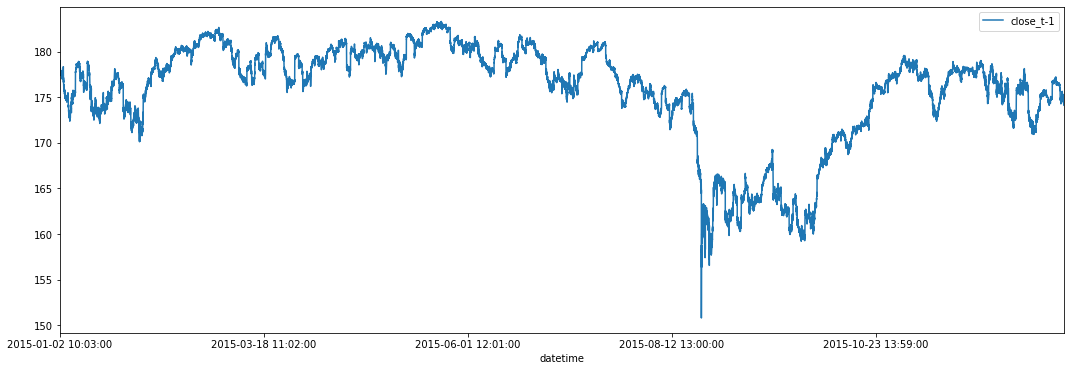

In [33]:
# Now plot close price and volume overtime.
import matplotlib.pyplot as plt
import pandas as pd

df.set_index('datetime',drop=True).plot(y=["close_t-1"], figsize=(18,6))
plt.show()

In [34]:
df.columns

Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'gap',
       'timestamp', 'close_t-1', 'close_t-2', 'close_t-3', 'close_t-4',
       'open_t-1', 'open_t-2', 'open_t-3', 'open_t-4', 'high_t-1', 'high_t-2',
       'high_t-3', 'high_t-4', 'low_t-1', 'low_t-2', 'low_t-3', 'low_t-4',
       'sma_5', 'sma_10', 'sma_20', 'sma_30', 'ema_5', 'ema_10', 'ema_20',
       'ema_30', 'wma_10', 'mom_10', 'stoch_slowk', 'stoch_slowd', 'macd_macd',
       'macd_macdsignal', 'macd_macdhist', 'rsi_10', 'willr_10', 'cci_10',
       'adx_10', 'aroon_aroondown', 'aroon_aroonup', 'bbands_upperband',
       'bbands_middleband', 'bbands_lowerband', 'trima_5', 'trima_10',
       'trima_20', 'trima_30', 'roc_10', 'rocr_10', 'stochf_fastk',
       'stochf_fastd', 'medprice_10', 'typprice_10', 'wclprice_10', 'atr_10',
       'macdfix_macd', 'macdfix_macdsignal', 'macdfix_macdhist', 'sar_10',
       'ppo_10', 'close_t+1', 'label'],
      dtype='object')

Start efts\5min-level\DOWJONES\DOWJONES_[2014-12-01_to_2015-01-01]_no_missing_data_market_hours_no_missing_data.csv
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\DOWJONES_[2014-12-01_to_2015-01-01]_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020.csv > C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\DOWJONES_[2014-12-01_to_2015-01-01]_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020.arff
Class distribution: 
0 in 0.5369135508454393%
1 in 0.4630864491545606%


<IPython.core.display.Javascript object>

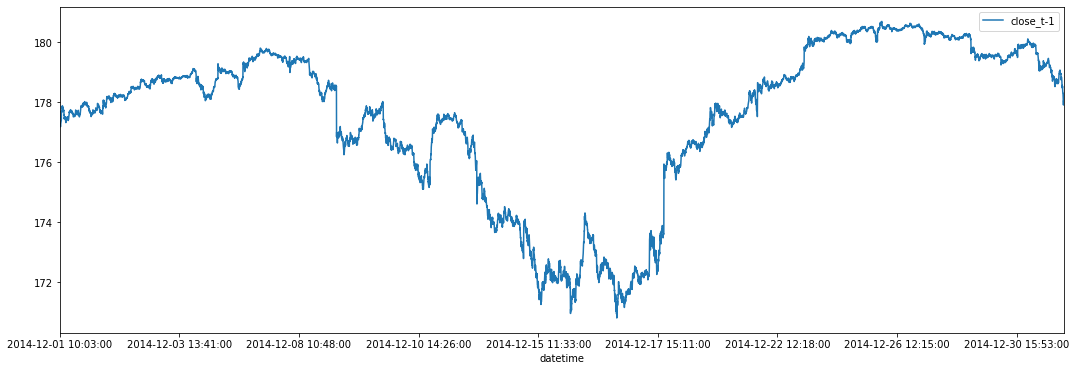

Start efts\5min-level\DOWJONES\DOWJONES_[2015-01-01_to_2016-01-01]_no_missing_data_market_hours_no_missing_data.csv
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\DOWJONES_[2015-01-01_to_2016-01-01]_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020.csv > C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\DOWJONES_[2015-01-01_to_2016-01-01]_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020.arff
Class distribution: 
0 in 0.5328964132462212%
1 in 0.4671035867537789%


<IPython.core.display.Javascript object>

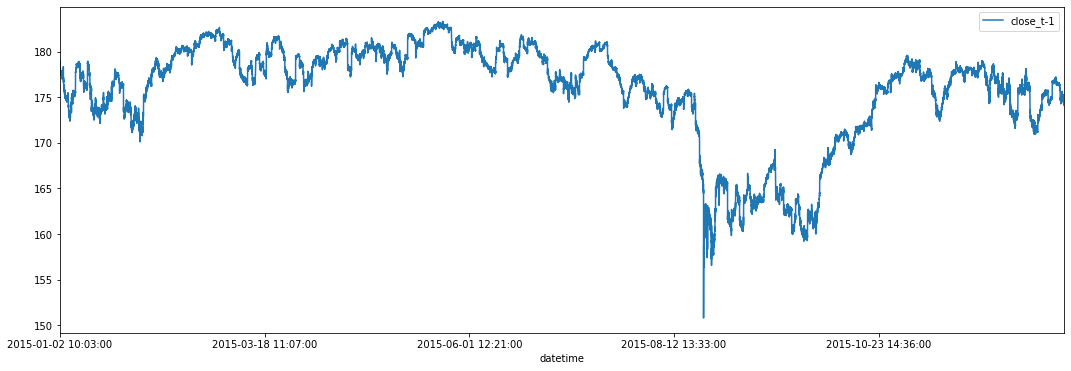

Start efts\5min-level\DOWJONES\DOWJONES_[2016-01-01_to_2017-01-01]_no_missing_data_market_hours_no_missing_data.csv
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\DOWJONES_[2016-01-01_to_2017-01-01]_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020.csv > C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\DOWJONES_[2016-01-01_to_2017-01-01]_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020.arff
Class distribution: 
0 in 0.5334419551934827%
1 in 0.4665580448065173%


<IPython.core.display.Javascript object>

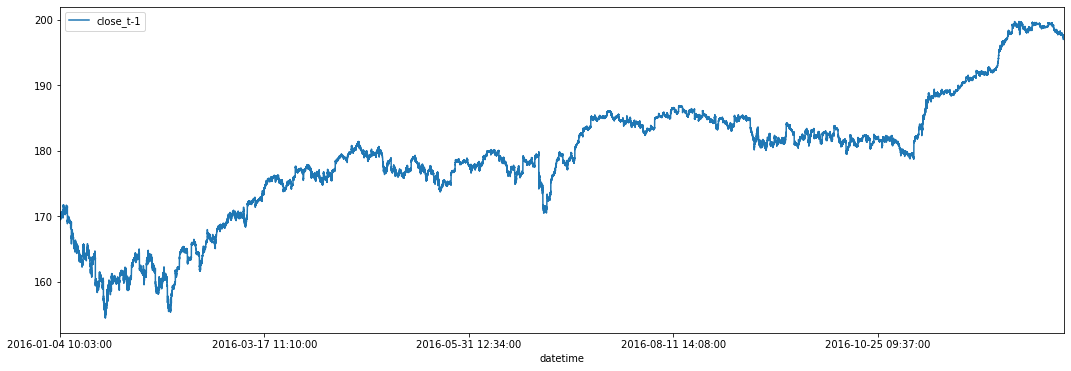

Start efts\5min-level\DOWJONES\DOWJONES_[2017-01-01_to_2018-01-01]_no_missing_data_market_hours_no_missing_data.csv
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\DOWJONES_[2017-01-01_to_2018-01-01]_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020.csv > C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\DOWJONES_[2017-01-01_to_2018-01-01]_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020.arff
Class distribution: 
0 in 0.5314172833440804%
1 in 0.4685827166559196%


<IPython.core.display.Javascript object>

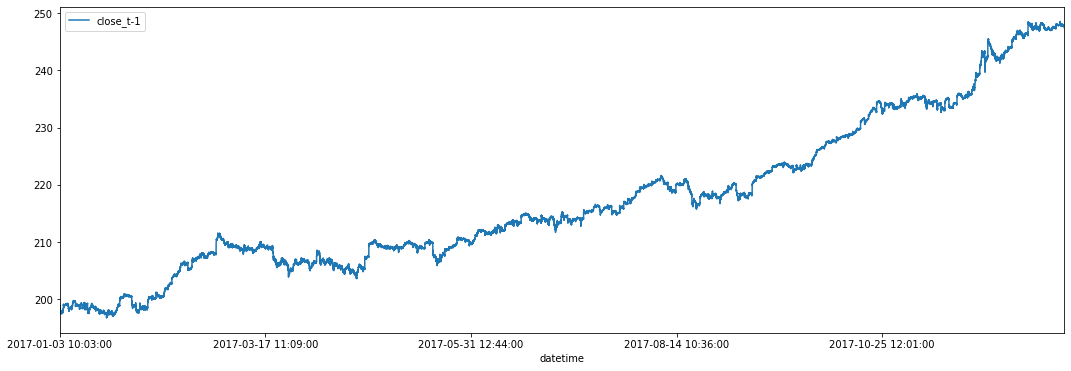

Start efts\5min-level\DOWJONES\DOWJONES_[2018-01-01_to_2019-01-01]_no_missing_data_market_hours_no_missing_data.csv
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\DOWJONES_[2018-01-01_to_2019-01-01]_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020.csv > C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\DOWJONES_[2018-01-01_to_2019-01-01]_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020.arff
Class distribution: 
0 in 0.5166496111338518%
1 in 0.4833503888661482%


<IPython.core.display.Javascript object>

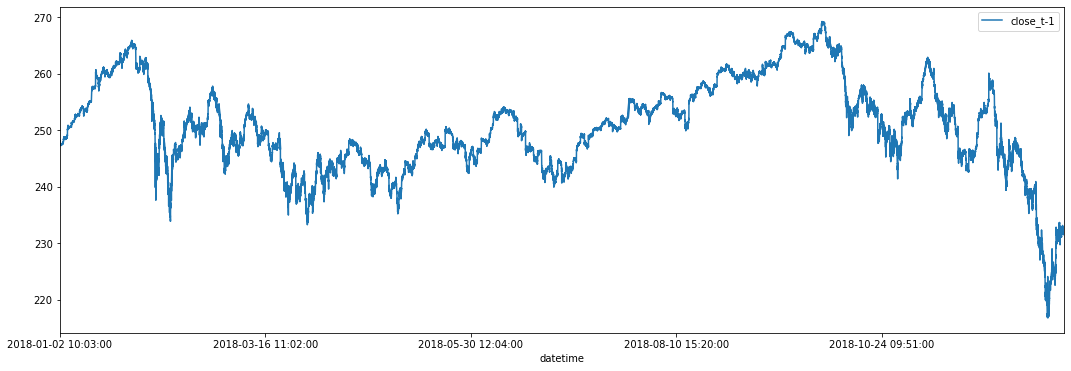

Start efts\5min-level\S&P500\S&P500_[2014-12-01_to_2015-01-01]_no_missing_data_market_hours_no_missing_data.csv
If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\S&P500_[2014-12-01_to_2015-01-01]_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020.csv > C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\S&P500_[2014-12-01_to_2015-01-01]_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020.arff
Class distribution: 
0 in 0.5213029623509973%
1 in 0.47869703764900273%


<IPython.core.display.Javascript object>

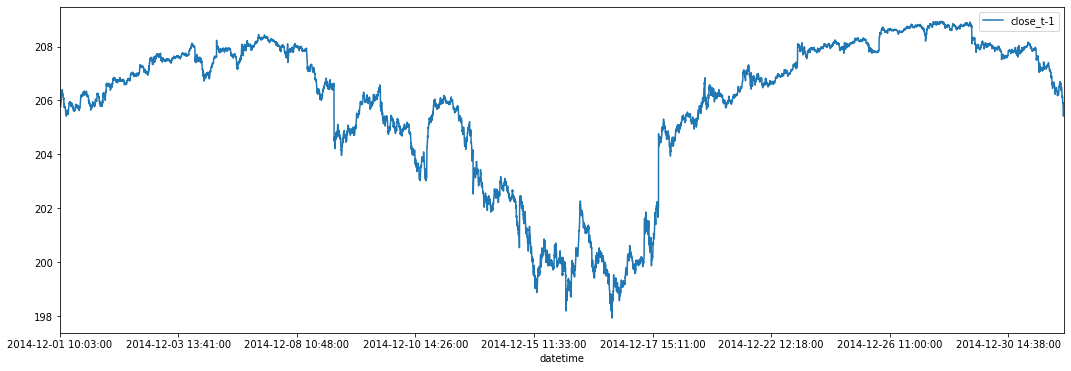

Start efts\5min-level\S&P500\S&P500_[2015-01-01_to_2016-01-01]_no_missing_data_market_hours_no_missing_data.csv


In [ ]:
# BATCH

# Paths for symbols
DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data'])
SOURCE_PATH=DATA_PATH 
RESULT_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output']) 

for file in files:
    filename = file.replace(SOURCE_PATH+os.sep,'')
    FIELD = 'close' # price->'ts' returns->'ret_ts' ts_with_added_noise-> 'ts_n2_post'
    print(f'Start {filename}')

    file = os.sep.join([SOURCE_PATH, filename])
    RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_'+level+'_indicators_best_no_filling_gaps_05062020.csv'])
    
    # Open file
    df=pd.read_csv(file, sep=';')
    
    #Add parameters to transform in TS
    timeseries=['close', 'open', 'high', 'low']
    #Length of the TS. How many values do we keep per serie. 
    # e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3
    length = 5

    # Add lagged times
    for column in timeseries:
        for i in range(1,length):
            df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed


    # all the numbers here and below assume a default time period for ta params of 10 mins averages
    # change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
    # in that case change as well the time tag '_10' with the corresponding one.
    default_timerange=10
    # Set extra timeranges for moving averages
    extra_timeranges=[default_timerange/2, default_timerange, default_timerange*2, default_timerange*3]

    # ###########################################
    # Iterate and run list of indicators selected
    # All of them produced for 25 prior mins of data 
    # ###########################################
    for ind in list(indicators):
        if ind not in ['adosc', 'obv', 'mfi']:  # avoiding indicators that need volume
            # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
            if ind in ['ema','sma','trima']:
                for timerange in extra_timeranges:
                    df[ind+'_'+str(int(timerange))] = get_indicator(ind)(df, timeperiod=timerange) 
            elif ind not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
                df[ind+'_'+str(int(default_timerange))] = get_indicator(ind)(df, timeperiod=(default_timerange))
            # Otherwise check the list of columns and return all
            else: 
                key_output=get_indicator(ind)(df, timeperiod=(default_timerange)) #, price='close')
                for j in range(0,len(list(key_output.columns))):
                    df[ind+'_'+key_output.columns[int(j)]] = key_output[key_output.columns[j]]

    def set_label(row):
        if row['close_t+1'] > row['close']: return 1
        else: return 0

    # One minute ahead closing price
    df['close_t+1']=df['close'].shift(-1)

    # Creating label/y to be predicted / independent (predicted) feature 'y' 
    df['label'] = df.apply(set_label, axis=1)
    df.dropna(inplace=True)
    
    # Select columns for output
    # best pool found through indicators grid search script
    columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                        'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                        'aroon_aroondown','aroon_aroonup','label']

    # Export processed data
    output = pd.DataFrame(df, columns=columns_selected)
    output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
    create_arff_file(RESULT_FILEPATH_PROCESSED) # export in ARFF

    # Printing classes distributions
    print("Class distribution: ")
    label_zero=len(df[df['label'] == 0])
    label_one=len(df[df['label'] == 1])
    #print(label_zero)
    #print(label_one)
    print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
    print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

    %notify -m "Parsing is finished"    
    
    # Now plot close price and volume overtime.
    df.set_index('datetime',drop=True).plot(y=["close_t-1"], figsize=(18,6))
    plt.show()    